# Определение стоимости автомобилей

Задача проекта - создать модель, определяющую рыночную стоимость автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

Загрузим необходимые нам библиотеки и ознакомимся с данными

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import lightgbm as lgb

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


В датафрейме 4 дубликата - избавимся от них:

In [5]:
df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

4

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Датасет содержит информацию о дате скачивания анкеты из базы, цене авто, годе и месяце регистрации автомобиля, технических характеристиках, комплектации авто, а так же о том, была машина в ремонте или нет, когда была создана анкета, количестве фотографий автомобиля, почтовом индексе пользователя и дате его последней активности. 

В датасете требуется привести данные к нужному формату: все даты сохранены в формате object.

Пропуски в датасете содержатся только в столбцах с категориальными данными ("тип двигателя", "тип КП", "модель", "тип топлива", "был ремонт"). Неизвестные значения в столбце model заполнены значением 'other' - заполним так же остальные пропуски в этом столбце. В остальных столбцах с пропусками заполним их значением unknown.

In [8]:
df['Model'] = df['Model'].fillna('other')
df = df.fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [9]:
df['PostalCode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: PostalCode, Length: 8143, dtype: int64

Столбец "Почтовый индекс" содержит **не** уникальные значения, т.е. не является id.

Посмотрим на данные в столбце Количество фотографий:

In [10]:
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Столбец Количество фотографий целиком состоит из нулей - судя по всему, произошла ошибка при загрузке данных. Вввиду того, что у нас отсутствует возможность запросить эти данные, столбец нужно удалить - в нашем исследовании он нам не поможет. 

Приведем данные в столбцах с датами к нужному формату:

In [11]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%d %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  object        
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Сама по себе информация о дате последней активности и дате создания объявления не представляет ценности для будущей модели. На их основе создадим и добавим столбцы с информацией об общем времени активности объявления. Нули округлим до единицы.

In [12]:
df['days_active'] = (df['LastSeen'] - df['DateCreated']).astype('timedelta64[D]').astype('int')
df['days_active'] = df['days_active'].replace(0, 1)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,days_active
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57,14
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,14
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46,22
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,1
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,6


Добавим столбец "месяц создания объявления" для того, чтобы взять в расчёт возможную сезонность продаж авто, и посмотрим на получившиеся значения:

In [13]:
df['month_created'] = pd.DatetimeIndex(df['DateCreated']).month

In [14]:
df['month_created'].value_counts()

3     296759
4      57119
2        397
1         70
11         9
12         9
9          3
8          2
6          1
Name: month_created, dtype: int64

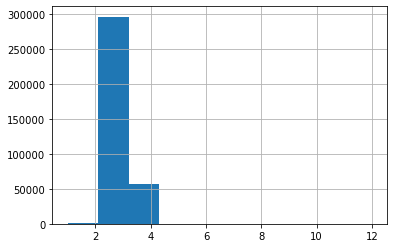

In [15]:
df['month_created'].hist();

Удивительно, но 84% объявлений было выложено в марте, и ещё 16% - в апреле. Связано ли это с тем, когда произошла загрузка данных?

In [16]:
df['MonthCrawled'] = pd.DatetimeIndex(df['DateCrawled']).month 
df['MonthCrawled'].value_counts()

3    296824
4     57545
Name: MonthCrawled, dtype: int64

In [17]:
df['YearCreated'] = pd.DatetimeIndex(df['DateCreated']).year 
df['YearCreated'].value_counts()

2016    354343
2015        25
2014         1
Name: YearCreated, dtype: int64

In [18]:
df['LastSeenMonth'] = pd.DatetimeIndex(df['LastSeen']).month 
df['LastSeenMonth'].value_counts()

4    200214
3    154155
Name: LastSeenMonth, dtype: int64

Да, связано: данные загрузили в апреле-мае 2016, таким образом в нашем датасете в основном содержатся объявления, созданные в апреле-мае того же года и незначительная часть тех, что были созданы раньше. Очевидно, что датасет содержит только те объявления, которые были активны на момент скачивания - данные в столбце "Месяц последней активности пользователя" почти полностью совпадает с месяцем скачивания объявления.

Мы могли бы учитывать сезонность продаж, которая, в свою очередь, могла бы влиять на цену автомобиля, если бы в нашем распоряжении были данные о дате создания анкеты как активных, так и уже неактивных объявлений. Поскольку таких данных нет, с большой вероятностью данные о дате создания объявления не помогут нам в создании модели, предсказывающей цену.

Удалим ненужные столбцы:

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  object        
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [20]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'RegistrationMonth', 'PostalCode',
              'LastSeen', 'DateCreated', 'days_active', 'month_created', 'MonthCrawled',
              'YearCreated', 'LastSeenMonth'], axis = 1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Переименуем столбцы: уберём верхний регистр и добавим пробелы там, где необходимо:

In [21]:
df.columns = df.columns.str.lower()
df = df.rename(columns={"vehicletype": "vehicle_type",
                        "registrationyear": "reg_year",
                        "fueltype": "fuel_type",
                        "notrepaired": "not_repaired"
                       })
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         354369 non-null  int64 
 1   vehicle_type  354369 non-null  object
 2   reg_year      354369 non-null  int64 
 3   gearbox       354369 non-null  object
 4   power         354369 non-null  int64 
 5   model         354369 non-null  object
 6   kilometer     354369 non-null  int64 
 7   fuel_type     354369 non-null  object
 8   brand         354369 non-null  object
 9   not_repaired  354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Рассмотрим данные в графе "мощность":

In [22]:
df['power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64

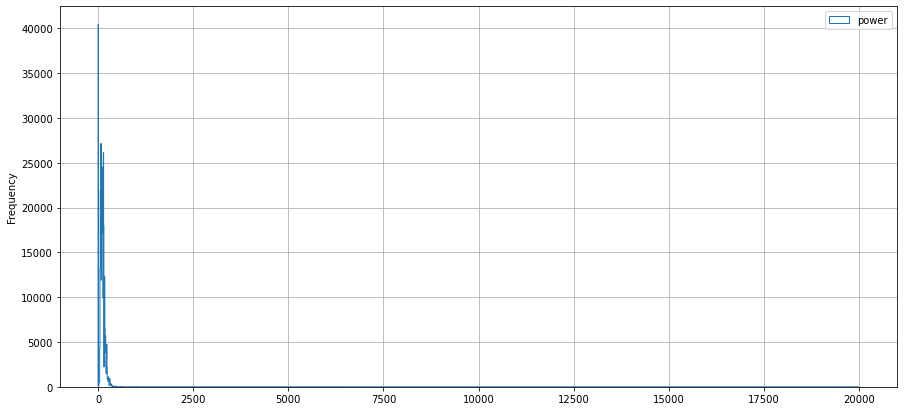

In [23]:
df.plot(kind='hist', y='power', histtype='step', bins=2500, figsize=(15, 7), grid = True);

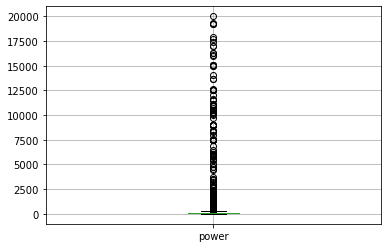

In [24]:
df.boxplot(['power']);

В столбце "мощность" много нулей, а так же содержатся выбросы - неправдоподобно большие значения мощности. Основываясь на открытых данных, определим верхнюю границу мощности на 650 л.с. Значения выше заменим на нули и будем заполнять как пропуски.

In [25]:
df[df['power'] > 650]

,price,vehicle_type,reg_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
1816,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2102,0,sedan,1999,unknown,1799,vectra,150000,petrol,opel,yes
3746,0,unknown,2017,manual,750,other,150000,petrol,smart,no
4060,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
...,...,...,...,...,...,...,...,...,...,...
348883,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,unknown
348968,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
351947,1500,bus,2001,manual,1001,zafira,5000,gasoline,opel,no
353493,12500,unknown,2017,manual,2000,other,60000,gasoline,chrysler,no


In [26]:
for i in range(len(df)):
    if df.loc[i, 'power'] > 650:
        df.loc[i, 'power'] = 0
        
df['power'].value_counts()

0      40587
75     24023
60     15897
150    14590
101    13298
       ...  
337        1
339        1
459        1
489        1
612        1
Name: power, Length: 453, dtype: int64

Будем исходить из того, что автомобили одного бренда, модели и типа кузова укомплектованы примерно одинаковыми по мощности двигателями. Создадим сводную таблицу, в которой отобразим среднее значение мощности исходя из указанных характеристик автомобиля. Сохраним эту таблицу в двух вариантах - с мультииндексом и без него.

In [27]:
mean_powers = df.query('power > 10').pivot_table(index=['brand','model','vehicle_type'],values='power',aggfunc='mean')
mean_powers_reseted = mean_powers.reset_index()
mean_powers

power
brand      model    vehicle_type            
alfa_romeo 145      coupe         103.000000
                    other         100.000000
                    sedan         120.916667
                    small         108.888889
                    unknown       103.833333
...                                      ...
volvo      v70      wagon         168.274783
           xc_reihe sedan         160.000000
                    suv           187.677725
                    unknown       175.600000
                    wagon         182.487805

[1649 rows x 1 columns]

Проверим, не потеряли ли мы данные: сравним количество уникальных значений в сводной таблице и в исходной:

In [28]:
print(len(mean_powers_reseted['brand'].unique()),len(df['brand'].unique()))
print(len(mean_powers_reseted['model'].unique()),len(df['model'].unique()))
print(len(mean_powers_reseted['vehicle_type'].unique()),len(df['vehicle_type'].unique()))

40 40
249 250
9 9


Отыщем потерявшуюся модель:

In [29]:
full_models = df['model']
powered_models = mean_powers_reseted['model']
missing = df.query('model not in @powered_models')
print(missing['model'])

234296    serie_1
280216    serie_1
Name: model, dtype: object


Мы потеряли Land Rover Serie 1 - таких объявлений всего два. Опираясь на открытые источники, выясняем, что мощность двигателя этих автомобилей примерно равна 50 л.с. - заполним вручную.

In [30]:
df.loc[234296, 'power'] = 50
df.loc[280216, 'power'] = 50

Напишем функцию, заменяющую неправдоподобно низкие значения мощности двигателя (меньше 11 л.с. включая 0) средним значением мощности для автомобилей того же бренда, модели и типа кузова:

In [31]:
def power(row):
    power = row['power'] 
    brand = row['brand']
    model = row['model']
    vehicle_type = row['vehicle_type']
    new_power = power
    if power < 11:
        try:
            new_power = mean_powers.loc[(brand, model, vehicle_type)].iloc[0]
        except:
            new_power = 0
    return new_power
 
df['power'] = df.apply(power, axis = 1)

In [32]:
df['power'].value_counts()

75.000000     24040
60.000000     15903
150.000000    14611
101.000000    13302
140.000000    12855
              ...  
67.222222         1
97.500000         1
99.600000         1
157.800000        1
442.000000        1
Name: power, Length: 1494, dtype: int64

In [33]:
df[df['power']<50]

,price,vehicle_type,reg_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
193,1200,coupe,1990,manual,45.0,other,150000,petrol,volkswagen,unknown
208,2250,small,2001,unknown,41.0,fortwo,150000,gasoline,smart,no
212,1200,small,2002,manual,45.0,lupo,150000,petrol,volkswagen,no
232,1000,suv,1982,manual,41.0,other,150000,petrol,suzuki,unknown
322,3300,small,2006,auto,41.0,fortwo,125000,gasoline,smart,no
...,...,...,...,...,...,...,...,...,...,...
354175,0,unknown,1995,manual,45.0,polo,150000,petrol,volkswagen,unknown
354223,200,small,1991,manual,45.0,polo,150000,petrol,volkswagen,yes
354266,399,small,1992,manual,45.0,polo,150000,petrol,volkswagen,unknown
354277,0,small,1999,manual,37.0,arosa,150000,petrol,seat,yes


После всех преобразований в нашем датасете осталось около 6 тысяч объявлений со значением мощности ниже 50 л.с. Такие данные не актуальны для нашего исследования, удалим их и посмотрим на распределение значений мощности в датасете после проведённой работы:

In [34]:
df.drop(df[df['power']<50].index, inplace=True)

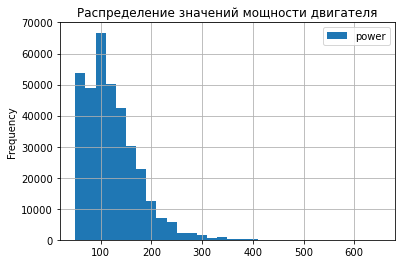

In [35]:
df.plot(kind='hist', y='power', bins=30, grid = True, title='Распределение значений мощности двигателя');

Посмотрим на уникальные значения в столбце Год регистрации:

In [36]:
sorted(df['reg_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1928,
 1929,
 1930,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,
 8455,
 8500,

Сомнения вызывают объявления со значением года регистрации меньше 1910 и больше 2019, это аномалии. Для исследования нам так же не нужны данные старше 50 лет, будем обучать модель на актуальных данных.

In [37]:
len(df[(df['reg_year']>1969)&(df['reg_year']<2019)]) - len(df)

-1149

In [38]:
df.drop(df[(df['reg_year']<1969)].index, inplace=True)
df.drop(df[(df['reg_year']>2019)].index, inplace=True)

In [39]:
df.reset_index(drop=True)
df['reg_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1976, 1983, 1969, 1971, 1987, 1973, 1982, 1988, 1986, 1974,
       1979, 1970, 1978, 1972, 1977, 1975, 2019], dtype=int64)

In [40]:
df['kilometer'].unique()

array([150000, 125000,  90000,  40000,  30000,  70000, 100000,  60000,
         5000,  20000,  80000,  50000,  10000], dtype=int64)

Рассмотрим распределение в столбце Цена:

In [41]:
df['price'].value_counts()

0       10318
500      5397
1500     5295
1000     4544
1200     4519
        ...  
2683        1
634         1
378         1
1401        1
8188        1
Name: price, Length: 3717, dtype: int64

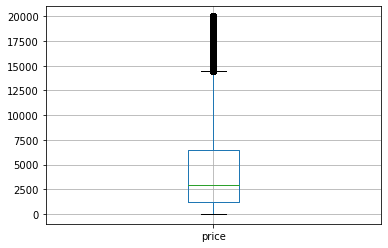

In [42]:
df[df['price'] > 0].boxplot(['price']);

Столбец содержит большое количество нулей и выбросов, но поскольку этот параметр является таргетом в нашей выборке, никаких модификаций с ним мы проводить не будем.

Предобработка завершена. Посмотрим на наши данные:

In [43]:
df.describe()

,price,reg_year,power,kilometer
count,347103.000000,347103.000000,347103.000000,347103.000000
mean,4458.555204,2003.356367,120.489791,128625.119921
std,4518.349390,6.871467,52.079598,37457.693092
min,0.000000,1969.000000,50.000000,5000.000000
25%,1100.000000,1999.000000,80.000000,125000.000000
50%,2799.000000,2003.000000,110.007143,150000.000000
75%,6499.000000,2008.000000,147.000000,150000.000000
max,20000.000000,2019.000000,650.000000,150000.000000


Всё выглядит красиво и логично. Построим матрицу корреляции и посмотрим, есть ли зависимость между признаками:

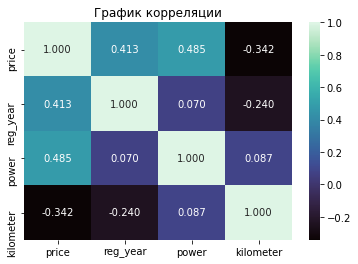

In [44]:
sns.heatmap(df.corr(), annot=True, fmt='.3f', cmap=sns.color_palette("mako", as_cmap=True))
plt.title("График корреляции");

Видим достаточно сильную прямую зависимость между ценой и мощностью двигателя и чуть менее выраженную между ценой и годом регистрации авто. Всё логично: чем новее автомобиль, тем выше его цена, и, как правило, автомобили с более мощным двигателем стоят дороже. Видим и обратную зависимость - между ценой и пробегом автомобиля, что тоже понятно: автомобили с меньшим пробегом будут стоить дороже.

## Обучение моделей

Разделим выборку на обучающую и тестовую:

In [45]:
features = df.drop('price', axis = 1)
target = df['price']

features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size = 0.25, random_state = 12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(260327, 9)
(260327,)
(86776, 9)
(86776,)


Проверим, какой объем нашей обучающей выборке составляют наблюдения, в которых цена равна нулю:

In [46]:
len(target_train[target_train==0]) / len(target_train)

0.030004571173946615

Нулевые значения составляют только 3% нашей обучающей выборки - избавимся от них. Тестовую выборку не меняем.

In [47]:
features_train.drop(features_train[target_train==0].index, inplace=True)
target_train.drop(target_train[target_train==0].index, inplace=True)
print(features_train.shape)
print(target_train.shape)

(252516, 9)
(252516,)


Создадим пайплайны для численных и категориальных признаков. Совместим кодирование категориальных и масштабирование численных признаков:

In [48]:
numerical = list(features_train.select_dtypes('number').columns)
categorical = list(features_train.select_dtypes('object').columns)
print(f"Численные признаки: {numerical}")
print(f"Категориальные признаки: {categorical}")

Численные признаки: ['reg_year', 'power', 'kilometer']
Категориальные признаки: ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']


In [49]:
cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

Согласно условиям нашей задачи, нужная метрика - RMSE. Создадим скорер для наших будущих моделей:

In [50]:
def rmse(target, predictions):
    return mean_squared_error(target, predictions) ** 0.5
    
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Мы готовы приступить к обучению моделей.

### 1. Модель градиентного бустинга LightGBM

Запустим GridSearch, чтобы подобрать лучшие гиперпараметры для нашей модели:

In [51]:
pipe_lgbm = Pipeline([('preprocessor', preprocessor),
                      ('lgbm', lgb.LGBMRegressor(random_state=12345))])

params_lgbm = [{
    'lgbm__num_leaves' : [50, 250, 400],
    'lgbm__learning_rate' : [0.2, 0.03],
    'lgbm__max_depth' : [5, 8, 10],
    'lgbm__n_estimators' : [50, 200, 500]
}]

In [52]:
print('Запуск GridSearch...')
lgbm = GridSearchCV(pipe_lgbm, params_lgbm, scoring=rmse_scorer, cv=3, verbose=1)
lgbm.fit(features_train, target_train)

print('Лучшие параметры:')
print(lgbm.best_params_)

Запуск GridSearch...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Лучшие параметры:
{'lgbm__learning_rate': 0.2, 'lgbm__max_depth': 10, 'lgbm__n_estimators': 500, 'lgbm__num_leaves': 250}


In [53]:
print('Среднее значение RMSE модели lgbm после кросс-валидации: {:.2f}'.format(abs(lgbm.best_score_)))

Среднее значение RMSE модели lgbm после кросс-валидации: 1599.46


Обучим лучшую модель и проверим её на тестовой выборке:

In [54]:
%%time

lgbm = Pipeline([('preprocessor', preprocessor),
                 ('lgbm', lgb.LGBMRegressor(learning_rate=0.2,
                                            max_depth=10,
                                            n_estimators=500,
                                            num_leaves=250,
                                            random_state=12345))])

print('Обучение...')
lgbm.fit(features_train, target_train)

print('Предсказание...')
target_pred = lgbm.predict(features_test)


Обучение...
Предсказание...
Wall time: 10.1 s


In [55]:
lgbm_rmse = mean_squared_error(target_test, target_pred) ** 0.5
print('Результат:')
print(f'RMSE модели градиентного бустинга на тестовой выборке: {lgbm_rmse}')

Результат:
RMSE модели градиентного бустинга на тестовой выборке: 1671.736181195034


### 2. Модель линейной регрессии

In [56]:
%%time

pipe_regression = Pipeline([('preprocessor', preprocessor),
                            ('regression', LinearRegression())])

pipe_regression.fit(features_train, target_train)
train_pred = pipe_regression.predict(features_train)
rmse = (mean_squared_error(target_train, train_pred)) ** 0.5
print(rmse)

2593.140385387759
Wall time: 10.2 s


In [57]:
predict = pipe_regression.predict(features_test)
lreg_rmse = mean_squared_error(predict, target_test) ** 0.5
print('Результат:')
print(f'RMSE модели линейной регрессии на тестовой выборке: {lreg_rmse}')

Результат:
RMSE модели линейной регрессии на тестовой выборке: 2643.2108434130337


### 3. Модель случайного леса

Так же запустим GridSearch для подбора оптимальных гиперпараметров

In [58]:
pipe_forest = Pipeline([('preprocessor', preprocessor),
                        ('forest', RandomForestRegressor(random_state=12345))])

params_forest = [{
    'forest__max_depth' : [8, 10, 15],
    'forest__n_estimators' : [50, 200, 500]
}]

print('Запуск GridSearch...')
forest = GridSearchCV(pipe_forest, params_forest, scoring=rmse_scorer, cv=3, verbose=1)
forest.fit(features_train, target_train)

print('Лучшие параметры:')
print(forest.best_params_)

Запуск GridSearch...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Лучшие параметры:
{'forest__max_depth': 15, 'forest__n_estimators': 500}


In [59]:
print('Среднее значение RMSE модели lgbm после кросс-валидации: {:.2f}'.format(abs(forest.best_score_)))

Среднее значение RMSE модели lgbm после кросс-валидации: 1732.00


Обучим лучшую модель и проверим её на тестовой выборке:

In [60]:
%%time

forest = Pipeline([('preprocessor', preprocessor),
                   ('forest', RandomForestRegressor(max_depth=15,
                                                    n_estimators=500,
                                                    random_state=12345))])

print('Обучение...')
forest.fit(features_train, target_train)

print('Предсказание...')
predict = forest.predict(features_test)
rmse_forest = mean_squared_error(target_test, predict) ** 0.5
print('RMSE модели случайного леса на тестовой выборке:', rmse_forest)

Обучение...
Предсказание...
RMSE модели случайного леса на тестовой выборке: 1803.8336409857154
Wall time: 1h 15min 6s


## Анализ моделей

Проверим наши модели на вменяемость, сравнив результат с дамми-регрессором:

In [61]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
predict = dummy_regr.predict(features_test)
dummy_rmse = mean_squared_error(target_test, predict) ** 0.5
print('RMSE константной модели:', dummy_rmse)

RMSE константной модели: 4510.092845460213


Представим полученные результаты в таблице:

In [63]:
data = [
    ['Модель градиентного бустинга LightGBM', int(lgbm_rmse), '10 сек'],
    ['Модель линейной регрессии', int(lreg_rmse), '10 сек'],
    ['Модель случайного леса', int(rmse_forest), '1 час 15 минут']
]
columns = ['Модель', 'Значение RMSE', 'Время выполнения']
results = pd.DataFrame(data=data, columns=columns)
results

,Модель,Значение RMSE,Время выполнения
0,Модель градиентного бустинга LightGBM,1671,10 сек
1,Модель линейной регрессии,2643,10 сек
2,Модель случайного леса,1803,1 час 15 минут


**Вывод**

Все наши модели прошли проверку на вменяемость - полученные значения RMSE значительно ниже, чем у константной модели. Наилучший результат показала модель градиентного бустинга LightGBM, причем как в отношении значения метрики, так и в отношении скорости обучения.

Для решения подобных задач рекомендуется *использовать модель LightGBM*.